In [1]:
import numpy as np
def Kuramoto(Theta,t,omega,N,K,mk,Aij):
    # print("Case m = 0")
    theta = 1*Theta
    theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
    dtheta = omega + K/mk*np.sum(Aij*np.sin(theta_j - theta_i),axis=0) 
    Theta[:N] = dtheta
    return Theta

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from numba import jit

In [3]:
@cuda.jit(nopython = True,chache=True)
def RKHG(f,y0,t,D,args=()):
    n = len(t)
    size = len(y0)
    y = np.zeros((n, size))
    y[0] = y0
    h = t[1] - t[0]
    sh = np.sqrt(h)
    for i in range(n - 1):
        S = np.random.choice([-1,1],size=size)
        dW = np.random.normal(0,1,size)*sh
        k1 = h*f(y[i],t[i],*args) + (dW - S*sh)*D
        k2 = h*f(y[i]+k1,t[i]+h,*args) + (dW + S*sh)*D
        y[i+1] = y[i] + 0.5*(k1+k2)
    return y

NameError: name 'cuda' is not defined

In [4]:
from scipy.special import erfinv
import scipy.stats as scs

def _make_init_theta_(seed,N):
    if type(seed)==str:
        init_theta= np.linspace(-np.pi,np.pi,N,endpoint=False)
    else:
        np.random.seed(seed)
        init_theta = np.random.uniform(-np.pi, np.pi, size=N)
    return init_theta
def Q_Normal(N, mean=0, sigma=1,seed=None):
    """return theta, omega, Kc"""
    init_theta = _make_init_theta_(seed,N)
    init_omega = np.array([mean +sigma*(2**0.5)*erfinv((2*i - N - 1)/(N+1)) for i in range(1,N+1)])
    Kc = 2 / (np.pi * scs.cauchy.pdf(mean, mean, sigma))
    return init_theta, init_omega, Kc

In [5]:
# @cuda.jit(nopython = True,chache=True)
@jit(nopython = True)
def RKHG(f,y0,t,D,args=()):
    n = len(t)
    size = len(y0)
    y = np.zeros((n, size))
    y[0] = y0
    h = t[1] - t[0]
    sh = np.sqrt(h)
    for i in range(n - 1):
        S = np.random.choice(np.array([-1,1]),size=size)
        dW = np.random.normal(0,1,size)*sh
        k1 = h*f(y[i],t[i],*args) + (dW - S*sh)*D
        k2 = h*f(y[i]+k1,t[i]+h,*args) + (dW + S*sh)*D
        y[i+1] = y[i] + 0.5*(k1+k2)
    return y


@jit(nopython = True,cache=True)
def RK4(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0

    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3 = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return y



# @cuda.jit#(nopython = True,chache=True)
@jit(nopython = True,cache=True)
def Kuramoto_SOL_CHIMERA(Theta,t,omega,N,Kij,alpha):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]

    theta_i= theta.reshape(1,-1)
    theta_j = theta_i.T
    # theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
    dtheta = omega +  np.sum(Kij*np.sin(theta_j - theta_i - alpha),axis=0)
    Theta[:N] = dtheta
    return Theta

In [6]:
N1 = 128
N2 = 128
theta_init = np.random.uniform(0,np.pi,(N1+N2))

In [7]:
N1 = 128
N2 = 128
theta_init = np.random.uniform(0,np.pi,(N1+N2)).astype(np.float32)
theta_init[:N1] = np.random.uniform(0,2*np.pi,(N1)).astype(np.float32)
theta_init[N1:] = np.random.uniform(0,2*np.pi,(N2)).astype(np.float32)
np.abs(np.mean(np.exp(theta_init*1j),axis=0))


0.045080222

In [8]:
2 - 3**0.5

0.2679491924311228

In [9]:
N1 = 128
N2 = 128 
theta_init = np.random.uniform(0,2*np.pi,(N1+N2))
theta_init[:N1] = np.ones_like(np.random.uniform(0,2*np.pi,(N1)))
theta_init[N1:] = np.random.uniform(0,2*np.pi,(N2))


A = 0.2
beta = 0.1
nu = (1-A)/2
mu = (1+A)/2

K_ij = nu*np.ones((N1+N2,N1+N2))
K_ij[:N1,:N1] = mu
K_ij[N1:,N1:] = mu



t_end = 100
dt = 0.01
r_last1 = 1
r_last2 = 1

print(rf'A = {A:.02f}, $\beta$ = {beta:.02f}')

num =0 
while min(r_last1,r_last2)>0.9:
    num +=1
    theta_init = np.random.uniform(-np.pi,np.pi,(N1+N2))
    theta_init[:N1] = np.ones_like(np.random.uniform(-np.pi,np.pi,(N1)))
    theta_init[N1:] = np.random.uniform(-np.pi,np.pi,(N2))
    
    t = np.arange(0, t_end+dt/2, dt)
    omega = 0
    alpha = np.pi/2 - beta

    sol = RK4(Kuramoto_SOL_CHIMERA,theta_init,t, args=(omega, N1+N2, K_ij,alpha))

    rabs1 = np.mean(np.exp(sol.T[:N1]*1j),axis=0)
    rabs2 = np.mean(np.exp(sol.T[N1:]*1j),axis=0)
    np.abs(np.mean(np.exp(theta_init[:N1]*1j),axis=0))
    r_I_1,psi_I_1 = abs(rabs1),np.angle(rabs1[0])
    r_I_2,psi_I_2 = abs(rabs2),np.angle(rabs2[0])
    # plt.axhline(r_I_1)
    # plt.axhline(r_I_2)
    r_last1 = r_I_1[-1]
    r_last2 = r_I_2[-1]
    print(num)
    
plt.figure()
plt.plot(t,r_I_1)
plt.plot(t,r_I_2)
plt.xlabel('t')
plt.ylabel(r'$r_{1,2}$')

print(min(r_last1,r_last2))


A = 0.20, $\beta$ = 0.10
1
2
3
4
5
6
7


0.984626449237887


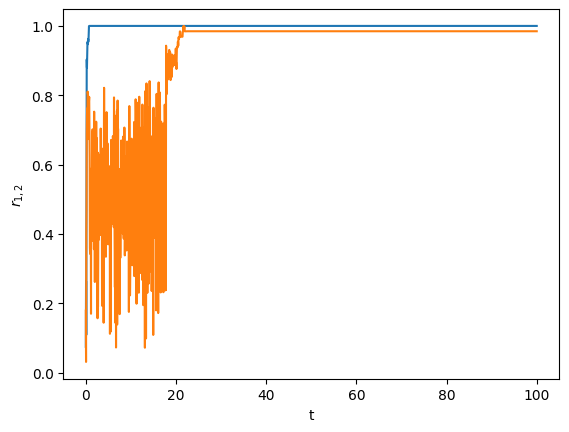

In [298]:
t_end = 100
t = np.arange(0, t_end+dt/2, dt)

sol = RK4(Kuramoto_SOL_CHIMERA,theta_init,t, args=(omega, N1+N2, K_ij,alpha))

rabs1 = np.mean(np.exp(sol.T[:N1]*1j),axis=0)
rabs2 = np.mean(np.exp(sol.T[N1:]*1j),axis=0)
np.abs(np.mean(np.exp(theta_init[:N1]*1j),axis=0))
r_I_1,psi_I_1 = abs(rabs1),np.angle(rabs1[0])
r_I_2,psi_I_2 = abs(rabs2),np.angle(rabs2[0])
# plt.axhline(r_I_1)
# plt.axhline(r_I_2)
plt.figure()
plt.plot(t,r_I_1)
plt.plot(t,r_I_2)
plt.xlabel('t')
plt.ylabel(r'$r_{1,2}$')
r_last1 = r_I_1[-1]
r_last2 = r_I_2[-1]
print(min(r_last1,r_last2))

In [279]:
np.ceil(16/16)

1.0

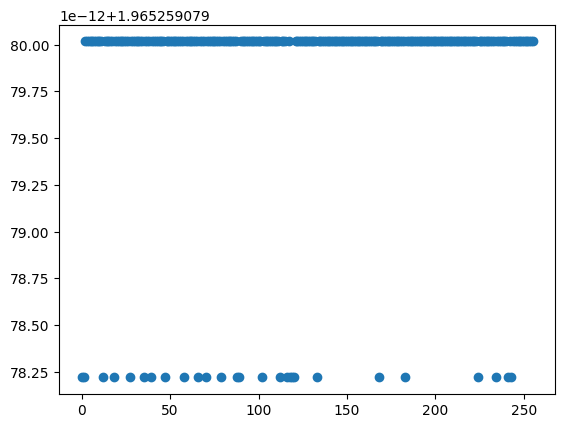

In [280]:
# plt.scatter(np.arange(N1+N2),sol[-1]%(np.pi*2))
plt.scatter(np.arange(N1+N2),sol[-100]%(np.pi*2))


(array([  0., 128.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([0.        , 0.33069396, 0.66138793, 0.99208189, 1.32277585,
        1.65346982, 1.98416378, 2.31485774, 2.64555171, 2.97624567,
        3.30693964, 3.6376336 , 3.96832756, 4.29902153, 4.62971549,
        4.96040945, 5.29110342, 5.62179738, 5.95249134, 6.28318531]),
 <BarContainer object of 19 artists>)

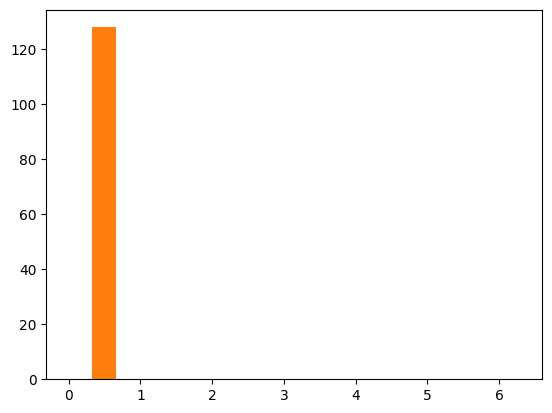

In [163]:
bins = np.linspace(0,2*np.pi,20)
plt.hist((sol[-1]%(np.pi*2))[:N1],bins=bins)
plt.hist((sol[-1]%(np.pi*2))[N1:],bins=bins)
# plt.hist((sol[-1][N1:]),bins=50)#%(np.pi*2))[N1:],bins=bins)
# plt.hist(sol[-1][N1:])

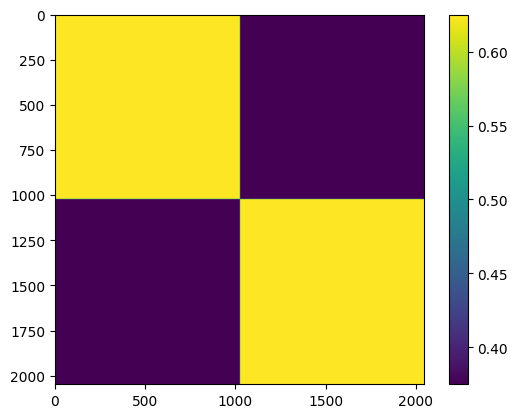

In [713]:
plt.imshow(K_ij)
plt.colorbar()


In [39]:
# # @jit(nopython=True)
# def get_order_parameter(theta,N):
#     ''' get theta and return r and theta'''
#     rpsi = 1/N*np.sum(np.exp(1j*theta))
#     r = np.abs(rpsi)
#     psi = np.angle(rpsi)
#     return r,psi

# # @jit(nopython=True)
# def Kuramoto_mf(Theta,t,omega,N,K):
#     # print("Case m = 0")
#     Theta = Theta.copy()
#     theta = Theta[:N]
#     r,psi = get_order_parameter(theta,N)
#     dtheta = omega + K*r*np.sin(psi - theta)
#     Theta[:N] = dtheta
#     return Theta


# def Kuramoto(Theta,t,omega,N,K,mk,Aij):
#     # print("Case m = 0")
#     Theta = Theta.copy()
#     theta = Theta[:N]
#     theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
#     dtheta = omega + K/mk*np.sum(Aij*np.sin(theta_j - theta_i),axis=0) 
#     Theta[:N] = dtheta
#     return Theta

# # @jit(nopython=True)
# def Kuramoto_mf_AR(Theta,t,omega,N,K,b):
#     # print("Case m = 0")
#     Theta = Theta.copy()
#     theta = Theta[:N]
#     r,psi = get_order_parameter(theta,N)
#     dtheta = omega + K*r*np.sin(psi - theta) - b*np.sin(theta)
#     Theta[:N] = dtheta
#     return Theta


# def Kuramoto_AR(Theta,t,omega,N,K,mk,Aij,b):
#     # print("Case m = 0")
#     Theta = Theta.copy()
#     theta = Theta[:N]
#     theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
#     dtheta = omega +  K/mk*np.sum(Aij*np.sin(theta_j - theta_i),axis=0)  - b*np.sin(theta)
#     Theta[:N] = dtheta
#     return Theta

# def get_order_parameter_ann(theta,N,mk,DEGT):
#     ''' get theta and return r and theta'''
#     rpsi = 1/(N*mk)*np.sum(DEGT*np.exp(1j*theta))
#     r = np.abs(rpsi)
#     psi = np.angle(rpsi)
#     return r,psi



# def Kuramoto_AMF_AR(Theta,t,omega,N,K,mk,DEGT,b):
#     # print("Case m = 0")
#     Theta = Theta.copy()
#     theta = Theta[:N]
#     r,psi = get_order_parameter_ann(theta,N,mk,DEGT)
#     dtheta = omega + K/mk*r*DEGT.flatten()*np.sin(psi - theta) - b*np.sin(theta)
#     Theta[:N] = dtheta
#     return Theta


In [ ]:
mk = 5
N = 1000
p = mk/(N)
# G = nx.erdos_renyi_graph(N,p)
G = nx.barabasi_albert_graph(N,5)

In [ ]:
A = nx.adjacency_matrix(G)
Aij = A.todense()
Deg = Aij.sum(axis=1)
DegT = Deg.reshape(-1,1)
mk = Deg.mean()
mk

9.95

# 캡스톤

In [732]:
A1_xg = 1.7
A2_xg = 1.4
A2_Ag = 1.4

A1_prob = A1_xg/(A1_xg+A2_xg)
A2_prob = 1 - A1_prob


In [733]:
A1_xg -  A2_Ag

0.30000000000000004

In [737]:
A1_prob, A2_prob

(0.5483870967741936, 0.4516129032258064)

In [738]:
np.random.rand()

0.015843059113251345